## Generic Capital Adjustment Problem
### For GMM


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantecon.markov.approximation import tauchen
from numba import typeof, jit, njit, prange, float64, int64


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
δ = 0.06
α = 0.6
β = 0.96

# shocks
ρ_a = 0.78
σ_a = 0.1
μ_a = 0.00
naa = 20
mc_A = tauchen(ρ_a, σ_a, μ_a, m=2, n=naa)
A_array, PA = mc_A.state_values, mc_A.P
A_array = np.exp(A_array)

# price
ρ_p = 0.7
σ_p = 0.3
μ_p = 0.9
npp = 10
mc_p = tauchen(ρ_p, σ_p, μ_p, m=2, n=npp)
p_array, Pp = mc_p.state_values, mc_p.P

# discretization: k is a "continuous" choice
nkk = 100
kmax = 10
kmin = 0.01
k_grid = np.linspace(kmin, kmax, nkk)

# unified exogenous states
n_exo = naa * npp

P_exo = np.empty((n_exo, n_exo))
exo_pos = np.empty((n_exo, 2), dtype=np.int8)
exo_key = np.empty((n_exo, 2))

index = 0

for j in range(naa): #aggre. shock
    for s in range(npp): #r.e. price

        # index the variable
        exo_pos[index,0], exo_key[index,0] = j, A_array[j]
        exo_pos[index,1], exo_key[index,1] = s, p_array[s]

        # creating the transition matrix
        for j1 in range(naa):
            for s1 in range(npp):
                index1 = j1 * npp + s1
                P_exo[index, index1] = PA[j,j1] * Pp[s,s1]

        # correction for roundoff error
        P_exo[index,:] = P_exo[index,:] / np.sum(P_exo[index,:])

        index = index + 1

In [3]:
@njit
def r_func(A, k):
    return A * k ** α

@njit(parallel=True)
def flow_profit():
    profit_tensor = np.empty((n_exo, nkk, nkk)) # (A, p, k, k')
    for i_exo in prange(n_exo):
        iA, A = exo_pos[i_exo, 0], exo_key[i_exo, 0]
        ip, p = exo_pos[i_exo, 1], exo_key[i_exo, 1]
        for ik in prange(nkk):
            k = k_grid[ik]
            profit_tensor[i_exo, ik, :] = r_func(A, k_grid) - p * (k_grid - (1 - δ) * k)
    return profit_tensor

@njit(parallel=True)
def T(v):
    Tv = np.zeros_like(v)
    pol_k = np.empty_like(v, dtype=np.int8)

    for i_exo in prange(n_exo):
        iA, A = exo_pos[i_exo, 0], exo_key[i_exo, 0]
        ip, p = exo_pos[i_exo, 1], exo_key[i_exo, 1]
        for ik in prange(nkk):
            k = k_grid[ik]
            rhs_vec = r_func(A, k_grid) - p * (k_grid - (1 - δ) * k) \
                        + β * (P_exo[i_exo,:] @ v[:,ik])

            k1_loc = np.argmax(rhs_vec)
            pol_k[i_exo,ik] = k1_loc
            Tv[i_exo,ik] = rhs_vec[k1_loc]

    return Tv, pol_k

@njit
def VFI(v0, tol=1e-6, max_iter=1000):
    error = 1
    it = 0
    v = v0
    while error > tol and it < max_iter:
        vnew, pol_k = T(v)
        error = np.amax(np.abs(vnew - v))
        v = vnew
        it += 1

    return vnew, pol_k


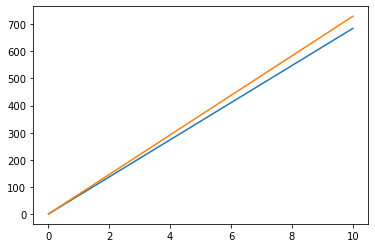

In [4]:
v0 = np.ones((n_exo, nkk), order="F")
v_ct_star, pol_k_idx = VFI(v0)
plt.plot(k_grid, v_ct_star[0,:])
plt.plot(k_grid, v_ct_star[-1,:])
# unravel the exogenous states
pol_kk_idx = np.empty((naa, npp, nkk), dtype=np.int8)
vv_star = np.empty((naa, npp, nkk))
for i_exo in range(n_exo):
    iA = exo_pos[i_exo, 0]
    ip = exo_pos[i_exo, 1]
    for ik in range(nkk):
        pol_kk_idx[iA,ip,ik] = pol_k_idx[i_exo,ik]
        vv_star[iA,ip,ik] = v_ct_star[i_exo,ik]

pol_kk = k_grid[pol_kk_idx]
pol_k = k_grid[pol_k_idx]


In [5]:
# for each firm
def sim_data_f(pol_k1_idx, mc_A, p_idx, seed, t_length, burning):
    A_idx = mc_A.simulate_indices(t_length+burning, random_state=seed)
    k_series_idx = np.empty(t_length+burning+1, dtype=np.int8)
    k_series_idx[0] = 0
    y_series = np.empty(t_length+burning)

    for t in range(t_length+burning):
        # states: A_t, p_t, k_t(inherited k)
        ip, iA = p_idx[t], A_idx[t]
        ik = k_series_idx[t]
        # policy: k_t+1
        ik1 = pol_k1_idx[iA,ip,ik]
        y_series[t] = r_func(A_array[iA], k_grid[ik1])
        k_series_idx[t+1] = ik1


    k_series = k_grid[k_series_idx]

    return k_series[-t_length:], y_series[-t_length:]

# panel
def sim_data_panel(pol_k1_idx, mc_A, mc_p, seed, N=5000, t_length=30):
    burning = 20
    p_idx = mc_p.simulate_indices(t_length+burning, random_state=seed)

    y_sim = np.empty((N, t_length))
    k_sim = np.empty_like(y_sim)

    for i in range(N):
        k_sim[i,:], y_sim[i,:] = sim_data_f(pol_k1_idx, mc_A, p_idx, i+7, t_length, burning)

    p_series = p_array[p_idx]
    p_series = p_series[-t_length:]
    return p_series, y_sim, k_sim

def data_todf(y, initial=1989):
    df = pd.DataFrame(y)
    df["firm_id"] = df.index + 1
    df_long = pd.melt(df, id_vars="firm_id", var_name = "year", value_name="data")
    df_long["year"] = df_long["year"] + initial
    return df_long


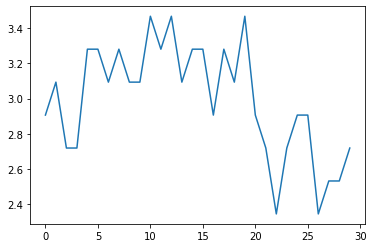

In [7]:
p_data, y_data, k_data = sim_data_panel(pol_kk_idx, mc_A, mc_p, 1234)
plt.plot(p_data)

y_df, k_df= data_todf(y_data), data_todf(k_data)
dataset = pd.merge(y_df, k_df, how='inner', on=("firm_id", "year"))
dataset = dataset.sort_values(by=["firm_id", "year"])
dataset = dataset.rename(columns={"data_x": "output", "data_y": "capital"})
dataset.to_csv("/Users/JuliaYI/Desktop/TA/homework_2022/hw3_data/revfunc_data.csv", header=True, index=False)

p_df = pd.DataFrame(p_data, columns=["price"])
p_df["year"] = p_df.index + 1989
p_df.to_csv("/Users/JuliaYI/Desktop/TA/homework_2022/hw3_data/price_data.csv", header=True, \
            columns=["year", "price"],index=False)